<h3 align="center"> $Double \: Pendulum$ </h3> 
<h3 align="center"> $-Abhisek \: Sarkar$ </h3>

In [1]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

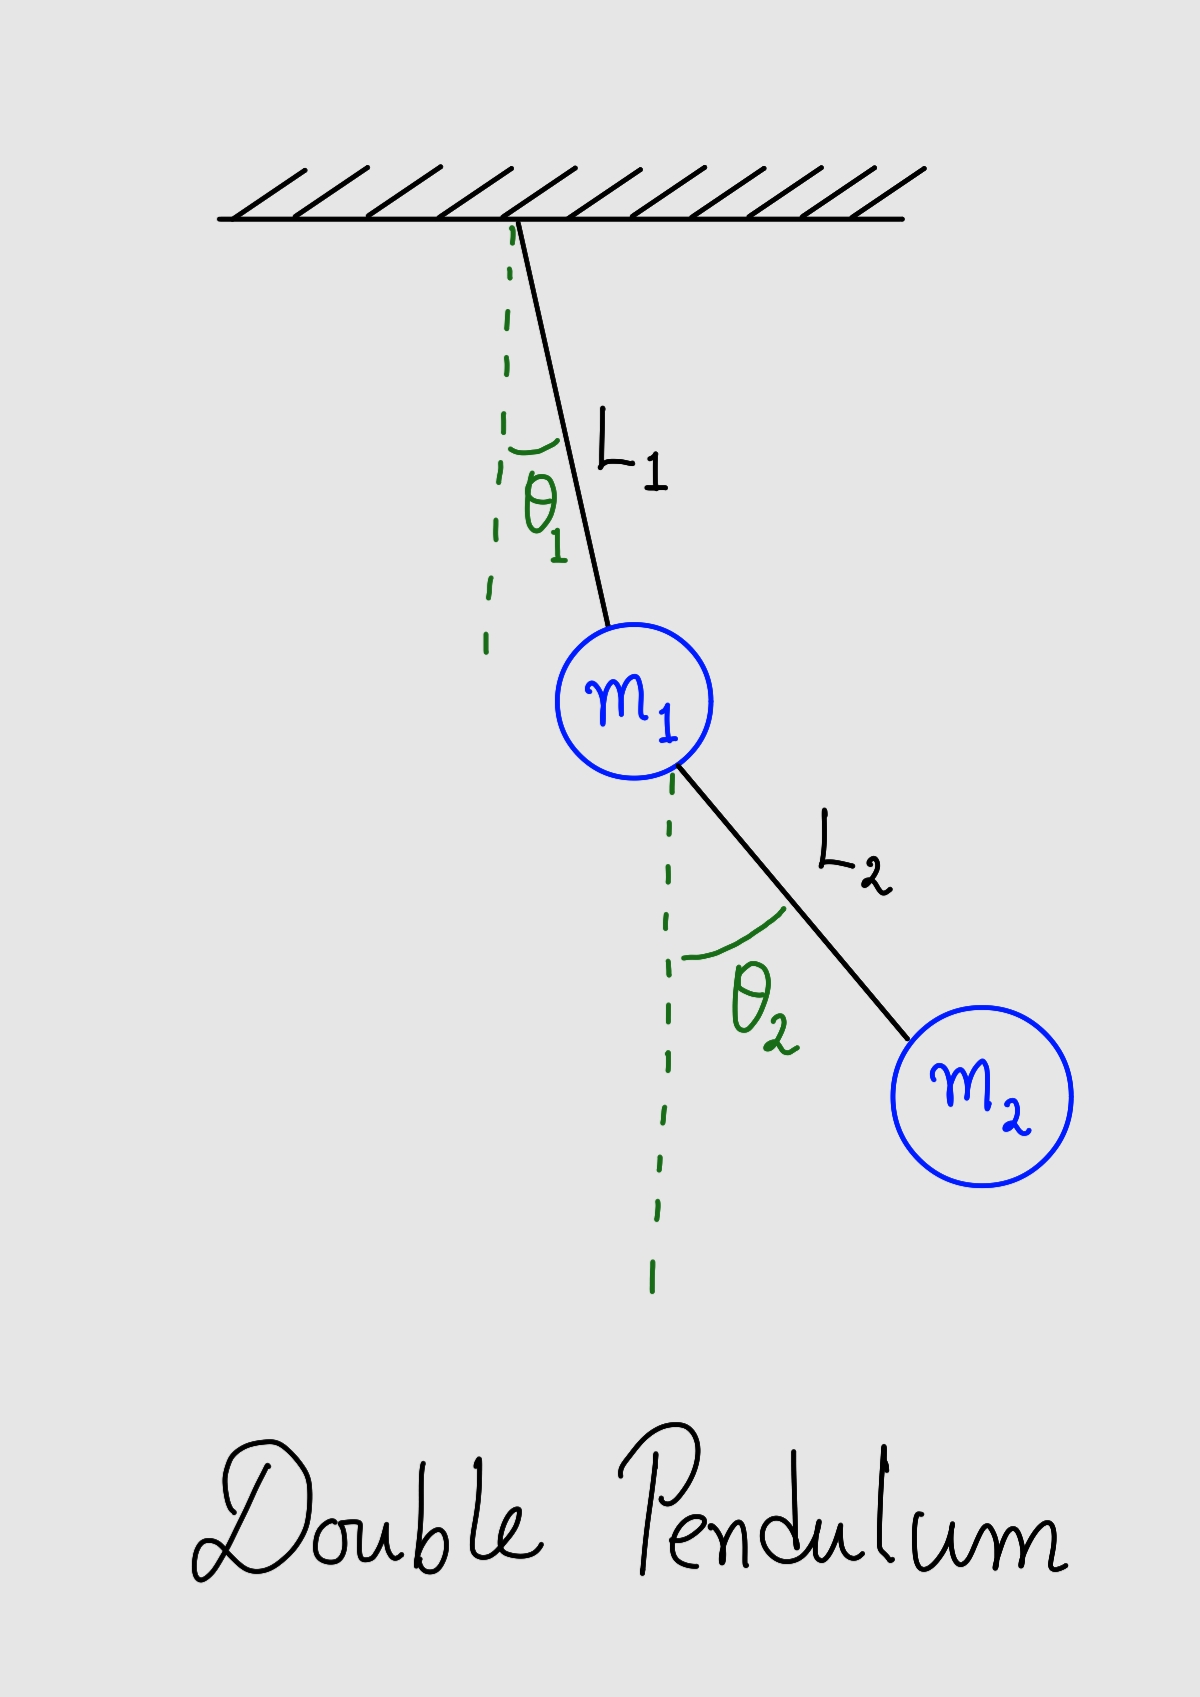

$Defination \: of\:all\:appropriate\:symbols\:using\:sympy:$

In [2]:
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m1 m2')
L1, L2 = smp.symbols('L1, L2')

$\theta_1\:and\:\theta_2\:are\:functions\:of\:time\:(which\:we\:will\:eventually\:solve\:for).\:We\:need\:to\:define\:them\:carefully.$

In [3]:
the1, the2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)

$Explicitly\:write\:them\:as\:functions\:of\:time\:t:$

In [4]:
the1 = the1(t)
the2 = the2(t)

$Defination\:of\:derivatives\:and\:second\:derivatives$

In [5]:
the1_d = smp.diff(the1, t)
the2_d = smp.diff(the2, t)
the1_dd = smp.diff(the1_d, t)
the2_dd = smp.diff(the2_d, t)

$Defination\:of\:x_1,\:y_1,\:x_2\:and\:y_2\:written\:in\:terms\:of\:the\:parameters\:above.$

In [6]:
x1 = L1*smp.sin(the1)
y1 = -L1*smp.cos(the1)
x2 = L1*smp.sin(the1)+L2*smp.sin(the2)
y2 = -L1*smp.cos(the1)-L2*smp.cos(the2)

$Now\:we\:will\:obtain\:the\:Lagrangian\:using\:these\:to\:define\:kinetic\:and\:potential\:energy\:for\:each\:mass.$

In [7]:
# Kinetic Energy
T1 = 1/2 * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T2 = 1/2 * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T = T1+T2
# Potential Energy
V1 = m1*g*y1
V2 = m2*g*y2
V = V1 + V2
# Lagrangian
L = T-V

$Now\:let's\:see\:the\:Lagrangian\:in\:output:$

In [8]:
L

L1*g*m1*cos(\theta_1(t)) - g*m2*(-L1*cos(\theta_1(t)) - L2*cos(\theta_2(t))) + 0.5*m1*(L1**2*sin(\theta_1(t))**2*Derivative(\theta_1(t), t)**2 + L1**2*cos(\theta_1(t))**2*Derivative(\theta_1(t), t)**2) + 0.5*m2*((L1*sin(\theta_1(t))*Derivative(\theta_1(t), t) + L2*sin(\theta_2(t))*Derivative(\theta_2(t), t))**2 + (L1*cos(\theta_1(t))*Derivative(\theta_1(t), t) + L2*cos(\theta_2(t))*Derivative(\theta_2(t), t))**2)

$Now\:we\:have\:to\:get\:Lagrange's\:equations:$


<center> $\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$ = 0
    <center> $\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$ = 0

In [9]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()

$Now\:we\:will\:solve\:Lagranges\:equations\:(this\:assumes\:that\:LE_1\:and\:LE_2\:are\:both\:equal\:to\:zero)$

In [10]:
sols = smp.solve([LE1, LE2], (the1_dd, the2_dd),
                simplify=False, rational=False)

$Now\:we\:have\\
dz_1/dt = ... \\
d\theta_1 /dt = z_1 \\
dz_1/dt = ... \\
d\theta_2 /dt = z_2\\
We\:need\:to\:convert\:the\:symbolic\:expressions\:above\:to\:numerical\:functions\:so\:we\:can\:use\:them\:in\:a\:numerical\:python\:solver.\:For\:this\:we \:use$ smp.lambdify

In [11]:
dz1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the1_dd])
dz2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the2_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

$Now\:we\:define\:\vec{S} = (\theta_1,z_1,\theta_2,z_2)\\
. IF\:we\:are\:going\:to\:use\:an\:ODE\:solver\:in\:python,\:we\:need\:to\:write\:a\:function\:that\:takes\:in\:\vec{S}\:and\:t\:and\:returns\:d\vec{S}/dt\:and\:depends\:only\:on\:\vec{S}\:and\:t$

In [12]:
def dSdt(S, t, g, m1, m2, L1, L2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
    ]

$Now\:we\:will\:solve\:the\:system\:of\:ODEs\:using\:scipys\:odeint\:method$

In [13]:
t = np.linspace(0, 40, 1001)
g = 9.81
m1=2
m2=1
L1 = 2
L2 = 1
ans = odeint(dSdt, y0=[1, -3, -1, 5], t=t, args=(g,m1,m2,L1,L2))

$25\:times\:per\:second\:(number\:of\:data\:points).\:This\:will\:be\:important\:when\:we\:will\:animate\:later.$

In [14]:
ans.T

array([[  1.        ,   0.87413906,   0.73333306, ...,  -0.88616579,
         -0.70444762,  -0.52275734],
       [ -3.        ,  -3.31025173,  -3.75998052, ...,   4.19459676,
          4.73165892,   4.24973584],
       [ -1.        ,  -0.78277685,  -0.52139856, ...,  12.25096793,
         11.77817817,  11.32116145],
       [  5.        ,   5.91440903,   7.24155048, ..., -11.00398717,
        -12.17998297, -10.37241422]])

$Can\:obtain\:\theta_2\:and\:\theta_1\:from\:the\:answer$

In [15]:
the1 = ans.T[0]
the2 = ans.T[2]

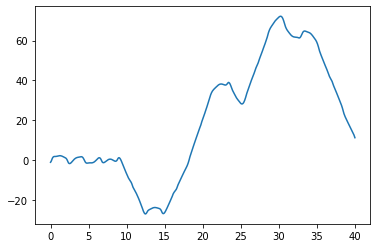

In [16]:
plt.plot(t, the2)

$Here\:is\:a\:function\:that\:takes\:in\:\theta_1\:and\:\theta_2\:and\:returns\:the\:location\:(x,y)\:of\:the\:two\:masses$

In [17]:
def get_x1y1x2y2(t, the1, the2, L1, L2):
    return (L1*np.sin(the1),
            -L1*np.cos(the1),
            L1*np.sin(the1) + L2*np.sin(the2),
            -L1*np.cos(the1) - L2*np.cos(the2))

x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0], ans.T[2], L1, L2)

$Then\:we\:can\:make\:an\:animation$

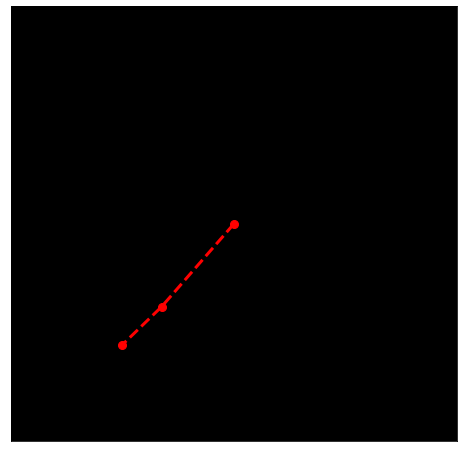

In [18]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=50)